In [1]:
from scipy.io import loadmat
import torch
from matplotlib import pyplot as plt
from vae import VAE
from losses import loss_function, BetaSchedulerCyclic, BetaSchedulerMono
import torchvision
from tqdm import tqdm
import os
import time
from torchvision.utils import save_image
from itertools import islice
from blocks import *
import numpy as np

In [2]:
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True

In [3]:
kwargs = {
    'HAS_BN': True,
    'SReLU': False,
    'HAS_ST': False,
    'DROPOUT': 0,
    'CIFAR': True,
    'DIRAC_INIT': False
}
# a = ResStem(w_in=3, w_out=64, **kwargs)
# print (kwargs['HAS_BN'])
a = ResStage(w_in=64, w_out=64, stride=2, d=1, **kwargs)
print (a)
# for m in a.modules():
#     if m i

ResStage(
  (b1): ResBlock(
    (f): BasicTransform(
      (a): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (a_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (a_relu): ReLU(inplace=True)
      (b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU(inplace=True)
  )
)


In [4]:
kwargs = {
    'HAS_BN': True,
    'SReLU': False,
    'HAS_ST': False,
    'DROPOUT': 0,
    'CIFAR': True,
    'DIRAC_INIT': False
}
kwargs_resnet_enc = {
    'HAS_BN': False,
    'SReLU': True,
    'HAS_ST': True,
    'DROPOUT': 0,
    'CIFAR': True,
    'DIRAC_INIT': True
}
kwargs_resnet_dec = {
    'HAS_BN': False,
    'SReLU': False,
    'HAS_ST': True,
    'DROPOUT': 0,
    'CIFAR': True,
    'DIRAC_INIT': False
}
z_size = 20
in_channels = 1
vae = VAE(in_channels=in_channels, latent_dim=z_size, res=32, stage_count=4, layer_mult=64, d=1,
          kwargs_enc=kwargs_resnet_enc, kwargs_dec=kwargs_resnet_dec)
vae.cuda()
vae.train()

[64, 128, 256, 512]
[1, 1, 1, 1]
0
1
2
3


VAE(
  (encoder): Sequential(
    (0): ResStem(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): SReLU(
        (srelu_relu): ReLU(inplace=True)
      )
    )
    (1): ResStage(
      (b1): ResBlock(
        (f): BasicTransform(
          (a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (a_relu): SReLU(
            (srelu_relu): ReLU(inplace=True)
          )
          (b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (relu): SReLU(
          (srelu_relu): ReLU(inplace=True)
        )
      )
    )
    (2): ResStage(
      (b1): ResBlock(
        (proj): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (f): BasicTransform(
          (a): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (a_relu): SReLU(
            (srelu_relu): ReLU(inplace=True)
          )
          (b): Con

In [5]:
# standardization
# torchvision.transforms.Normalize(
#  (0.1307,), (0.3081,))
slen = 32

batch_size_train = 64
batch_size_test = 256
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((slen,slen)),
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.Resize((slen,slen)),
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [6]:
# len(train_loader)

In [7]:
# examples = list(test_loader)
# print (examples[0][0].shape)
# print (examples[0][1].shape)
# print (examples[0][0][0].shape)

# plt.imshow (examples[0][0][0].view(slen,slen))
# plt.colorbar()
# plt.show()
# print (torch.mean(examples[0][0][0]))

In [8]:
# results = vae.encoder(examples[0][0][0].view(1,1,slen,slen).cuda())
# results[0].shape

In [9]:
# results = vae(examples[0][0][0].view(1,1,slen,slen).cuda())
# results[0].shape

In [10]:
# sample1 = torch.randn(64, z_size).view(-1, z_size).cuda()

In [11]:
# a = vae.decoder_input(sample1)
# print (a.shape)
# a = a.view(sample1.shape[0], vae.last_hdim, vae.code_len, vae.code_len)
# print (a.shape)

In [12]:
# a = vae.decoder(a)
# print (a.shape)

In [13]:
# a = BetaSchedulerMono()

# x = list(islice(a, 0, 4000))
# plt.plot(x)
# plt.show()

In [20]:
name='iso_mnist_'+time.strftime("%m-%d-%Y_%H-%M-%S")
os.makedirs(name, exist_ok=True)
recon_dir = os.path.join (name,'results_recon')
os.makedirs(recon_dir, exist_ok=True)
gen_dir = os.path.join (name,'results_gen')
os.makedirs(gen_dir, exist_ok=True)

lr = 0.0005
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=lr, betas=(0.5, 0.999)) #, weight_decay=1e-5
train_epoch = 50

re_loss_arr = []
kl_loss_arr = []
en_loss_arr = []
de_loss_arr = []
srelu_vals = []

# testing for recon during train_loader
# kl_loss_flag = False
# kl_i = 0

# for decode testing, batch size of 64
sample1 = torch.randn(64, z_size).view(-1, z_size).cuda()
beta_iter = BetaSchedulerCyclic(stop=.002, period=len(train_loader)*2)

for epoch in tqdm(range(train_epoch)):
    
    re_loss = 0
    kl_loss = 0
    en_loss = 0
    de_loss = 0
    
    for x in train_loader:
        x = x[0].cuda()
        vae.zero_grad()
        recon, mu, logvar = vae(x)

        loss = loss_function(recon, x, mu, logvar, kld_weight=next(beta_iter),
                             vae=vae, enc_ortho_coeff=1e-4, dec_ortho_coeff=0)
        loss['total'].backward()
        vae_optimizer.step()
        
        re_loss += loss['recon'].item()
        kl_loss += loss['KLD'].item()
        en_loss += loss['enc_ortho'].item()
        de_loss += loss['dec_ortho'].item()

        # plot every x
        re_loss_arr.append(loss['recon'].item())
        kl_loss_arr.append(loss['KLD'].item())
        en_loss_arr.append(loss['enc_ortho'].item())
        de_loss_arr.append(loss['dec_ortho'].item())
        
        
        # testing for recon during train_loader
#         if loss_kl < 0.000001:
#             kl_loss_flag = True
#         if kl_loss_flag:
#             resultsample = torch.cat([x, recon]) #unstandardization: * 0.3081 + 0.1307
#             resultsample = resultsample.cpu()
#             save_image(resultsample.view(-1, in_channels, slen*2, slen),
#                        recon_dir + '/' + str(epoch) + '_' + str(kl_i) + '.png')
#             kl_i += 1
        
        # SReLU value reading
#         for m in vae.modules():
#             if isinstance(m, SReLU):
#                 srelu_vals.append(torch.mean(m.srelu_bias).cpu().item())
#                 break

#     re_loss /= len(train_loader)
#     kl_loss /= len(train_loader)
#     en_loss /= len(train_loader)
#     de_loss /= len(train_loader)
#     re_loss_arr.append(re_loss)
#     kl_loss_arr.append(kl_loss)
    print('\n[%d/%d] recon: %.9f, KL: %.9f, enc: %.9f, dec: %.9f' % (
        (epoch + 1), train_epoch, re_loss, kl_loss, en_loss, de_loss))
   
    if epoch % 1 == 0:
        with torch.no_grad():
            vae.eval()
            x_rec, _, _ = vae(x)
            resultsample = torch.cat([x, x_rec]) #unstandardization: * 0.3081 + 0.1307
            resultsample = resultsample.cpu()
            save_image(resultsample.view(-1, in_channels, slen*2, slen),
                       recon_dir + '/' + str(epoch) + '.png')
            x_rec = vae.decode(sample1)
#             resultsample = x_rec * 0.3081 + 0.1307
            resultsample = x_rec.cpu()
            save_image(resultsample.view(-1, in_channels, slen, slen),
                       gen_dir + '/' + str(epoch) + '.png')
        vae.train()
        
    # checkpoint
    torch.save(vae.state_dict(), name + "/VAEmodel.pkl")
    
print("Training finish!... save training results")
torch.save(vae.state_dict(), "VAEmodel.pkl")
        

  0%|          | 0/50 [00:00<?, ?it/s]


[1/50] recon: 23.179794120, KL: 10.451438243, enc: 0.169009513, dec: 0.000000000


  2%|▏         | 1/50 [01:36<1:18:49, 96.52s/it]


[2/50] recon: 25.010042001, KL: 13.424142795, enc: 0.082307307, dec: 0.000000000


  4%|▍         | 2/50 [03:09<1:16:28, 95.60s/it]


[3/50] recon: 943.367762111, KL: 152264531755798739692747227136.000000000, enc: 704.099169549, dec: 0.000000000


  6%|▌         | 3/50 [04:43<1:14:30, 95.11s/it]


[4/50] recon: 964.522514105, KL: 131381780866890481883538259968.000000000, enc: 719.515449286, dec: 0.000000000


  8%|▊         | 4/50 [06:22<1:13:21, 95.69s/it]


KeyboardInterrupt: 

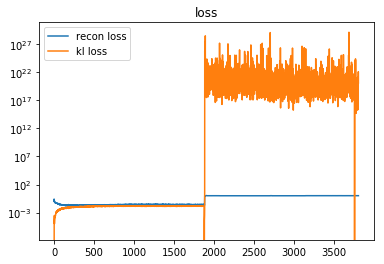

In [25]:
plt.plot(re_loss_arr, label='recon loss')
plt.plot(kl_loss_arr, label='kl loss')
plt.yscale('log')

plt.title('loss')
plt.legend()
plt.show()

In [23]:
np.argmax(kl_loss_arr)

3683

In [24]:
np.argmax(re_loss_arr[:2000])

1902

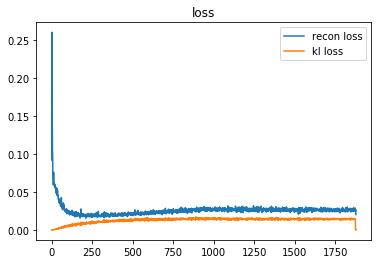

In [29]:
plt.plot(re_loss_arr[:1880], label='recon loss')
plt.plot(kl_loss_arr[:1880], label='kl loss')

plt.title('loss')
plt.legend()
plt.show()

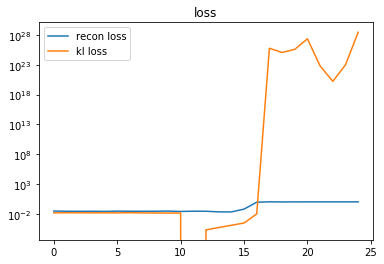

In [33]:
plt.plot(re_loss_arr[1865:1890], label='recon loss')
# plt.show()
plt.plot(kl_loss_arr[1865:1890], label='kl loss')
plt.yscale('log')
plt.title('loss')
plt.legend()
plt.show()

In [ ]:
for i in kl_loss_arr[1873:1890]:
    print (i.item())

In [ ]:
plt.plot(re_loss_arr[:2000], label='recon loss')
plt.plot(kl_loss_arr[:2000], label='kl loss')
plt.title('loss')
plt.legend()
plt.show()

In [ ]:
len(re_loss_arr)

In [ ]:
plt.plot(re_loss_arr, label='recon loss')

In [ ]:
plt.plot(srelu_vals)

In [ ]:
srelu_vals[1887]

In [ ]:
len(srelu_vals)

In [ ]:
for m in vae.modules():
    if isinstance(m, SReLU):
        print (torch.mean(m.srelu_bias).cpu().item())
        break

In [ ]:
plt.imshow(x.cpu())

In [ ]:
def load_latest

In [ ]:
kl_loss_arr[2] = 0

In [ ]:
plt.plot(re_loss_arr[3:], label='recon loss')
plt.plot(kl_loss_arr[3:], label='kl loss')
plt.title('loss')
plt.legend()
plt.show()

# ISOnet

In [ ]:
from ISONet.isonet.models import *

iso:

[1/50] recon: 0.485941466, KL: 0.044795726, enc: 0.000000000, dec: 0.000000000

[2/50] recon: 0.371852721, KL: 0.059582863, enc: 0.000000000, dec: 0.000000000


devel:

[1/50] recon loss: 0.255265573, KL loss: 0.118971909

[2/50] recon loss: 0.164801195, KL loss: 0.114278781


The difference is due to tanh. Why?
Should not have standardize

also for some reason init_coder makes kl loss very low and recon very hi,
for some reason prioritizes kl divergence
please investigate



[1/50] recon: 0.071641286, KL: 0.000074601, enc: 0.000000000, dec: 0.000000000

[2/50] recon: 0.059202360, KL: 0.000047522, enc: 0.000000000, dec: 0.000000000

  4%|▍         | 2/50 [01:45<42:10, 52.72s/it]


[3/50] recon: 0.060000994, KL: 0.000026837, enc: 0.000000000, dec: 0.000000000
^bn on decode

In [ ]:

[1/50] recon: 0.069124465, KL: 0.035863264, enc: 0.000000000, dec: 0.000000000

[2/50] recon: 0.058032005, KL: 29.810605342, enc: 0.000000000, dec: 0.000000000

  4%|▍         | 2/50 [01:45<42:23, 53.00s/it]


[3/50] recon: 0.055112885, KL: 5484343.761168436, enc: 0.000000000, dec: 0.000000000

  6%|▌         | 3/50 [02:38<41:29, 52.96s/it]


[4/50] recon: 0.054966730, KL: 0.034717195, enc: 0.000000000, dec: 0.000000000

  8%|▊         | 4/50 [03:30<40:27, 52.78s/it]


[5/50] recon: 0.054664997, KL: 0.015396994, enc: 0.000000000, dec: 0.000000000

 10%|█         | 5/50 [04:23<39:28, 52.64s/it]


[6/50] recon: 0.054381395, KL: 0.062738713, enc: 0.000000000, dec: 0.000000000


In [ ]:
recon suddenly spikes and kl drops: reason is not due to cyclic
it seems there is an ez way to get really low kl and ok recon by just spreading everything uniform